In [1]:
# Feature Engineering : Discipline of creation of new synthetic features based on existing data 

In [2]:
from src.setup import * 
%load_ext rpy2.ipython 

In [3]:
%%R 
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Datetime fields 

Concepts:

• Combining timestamp components

• Date/time operations in data frames

• Time deltas

• Duplicated timestamps (selection versus averaging)

• Resampling and grouping

• Interpolation at missing timestamps

In [6]:
%%bash 
zcat data/glarp/outside.gz | head -30

2003 07 25 16 04 27.500000
2003 07 25 16 07 27.300000
2003 07 25 16 10 27.300000
2003 07 25 16 13 27.400000
2003 07 25 16 16 27.800000
2003 07 25 16 19 27.500000
2003 07 25 16 22 27.600000
2003 07 25 16 25 27.600000
2003 07 25 16 28 27.700000
2003 07 25 16 31 27.575000
2003 07 25 16 34 27.700000
2003 07 25 16 37 27.600000
2003 07 25 16 40 27.500000
2003 07 25 16 43 27.475000
2003 07 25 16 46 27.400000
2003 07 25 16 49 27.400000
2003 07 25 16 52 27.200000
2003 07 25 16 55 27.000000
2003 07 25 16 58 27.300000
2003 07 25 17 01 27.500000
2003 07 25 17 04 27.600000
2003 07 25 17 07 27.275000
2003 07 25 17 10 27.300000
2003 07 25 17 13 27.200000
2003 07 25 17 16 26.900000
2003 07 25 17 19 26.700000
2003 07 25 17 22 26.400000
2003 07 25 17 25 26.500000
2003 07 25 17 28 26.475000
2003 07 25 17 31 26.400000


In [7]:
# Read the file with pandas as a space-delimited file 

In [9]:
temps = pd.read_csv('data/glarp/outside.gz',
                    sep=' ',
                    header=None,
                    names=['year', 'month', 'day', 'hour', 'minute', 'degrees'])
temps.head(5)

,year,month,day,hour,minute,degrees
0,2003,7,25,16,4,27.5
1,2003,7,25,16,7,27.3
2,2003,7,25,16,10,27.3
3,2003,7,25,16,13,27.4
4,2003,7,25,16,16,27.8


### Creating datetimes 

In [11]:
# Creating datetime index in pandas 

ts_fields = ['year', 'month', 'day', 'hour', 'minute']
temps.index = pd.to_datetime(temps[ts_fields])
temps.drop(columns=ts_fields, inplace=True)
temps

,degrees
2003-07-25 16:04:00,27.5
2003-07-25 16:07:00,27.3
2003-07-25 16:10:00,27.3
2003-07-25 16:13:00,27.4
...,...
2004-07-16 15:19:00,16.9
2004-07-16 15:22:00,16.8
2004-07-16 15:25:00,16.8
2004-07-16 15:28:00,16.4


In [13]:
temps.sort_index(inplace=True)
temps.index.is_monotonic_increasing

True

### Imposing regularity 

In [14]:
increments = temps.index.to_series().diff()
gaps = increments[increments > pd.Timedelta(minutes=3)]
gaps

2003-07-26 19:28:00   0 days 00:06:00
2003-07-27 09:10:00   0 days 00:06:00
2003-07-29 08:28:00   0 days 00:06:00
2003-07-29 11:43:00   0 days 00:06:00
                            ...      
2004-07-05 19:55:00   0 days 07:36:00
2004-07-06 09:28:00   0 days 00:06:00
2004-07-06 16:28:00   0 days 00:06:00
2004-07-14 04:04:00   0 days 00:06:00
Length: 160, dtype: timedelta64[ns]

In [15]:
with show_more_rows():
    print(gaps.sort_values(ascending=False).head(15))

2003-12-11 03:04:00   1 days 13:48:00
2004-04-28 00:31:00   0 days 13:06:00
2004-07-05 19:55:00   0 days 07:36:00
2003-12-18 09:25:00   0 days 06:33:00
2003-12-06 09:25:00   0 days 06:24:00
2003-12-29 08:46:00   0 days 06:03:00
2003-12-11 14:19:00   0 days 04:42:00
2004-04-04 03:01:00   0 days 01:03:00
2004-06-30 18:13:00   0 days 00:33:00
2003-11-24 08:04:00   0 days 00:30:00
2003-10-11 17:13:00   0 days 00:27:00
2003-12-13 17:10:00   0 days 00:15:00
2004-07-02 09:22:00   0 days 00:12:00
2004-06-30 03:07:00   0 days 00:12:00
2004-06-22 10:16:00   0 days 00:12:00
dtype: timedelta64[ns]


In [16]:
temps.loc['2003-07-26 19:22:00':'2003-07-26 19:28:00']

,degrees
2003-07-26 19:22:00,27.5
2003-07-26 19:28:00,27.1


In [17]:
small_steps = increments[increments < pd.Timedelta(minutes=3)]
small_steps.sort_values(ascending=False)

2003-10-03 12:04:00   0 days 00:02:00
2003-10-26 01:01:00   0 days 00:00:00
2003-12-24 15:10:00   0 days 00:00:00
2003-10-26 01:58:00   0 days 00:00:00
                            ...      
2003-10-26 01:13:00   0 days 00:00:00
2003-10-26 01:10:00   0 days 00:00:00
2003-10-26 01:07:00   0 days 00:00:00
2003-12-24 15:10:00   0 days 00:00:00
Length: 22, dtype: timedelta64[ns]

In [18]:
# Pandas is valiable of locate index with a particular datetime range 

temps.loc['2003-10-03 11:57':'2003-10-03 12:08']

,degrees
2003-10-03 11:58:00,13.0
2003-10-03 12:02:00,12.8
2003-10-03 12:04:00,12.8
2003-10-03 12:07:00,12.8


In [19]:
# Duplicated Timestamps 

temps[temps.index.duplicated(keep=False)]

,degrees
2003-10-26 01:01:00,1.9
2003-10-26 01:01:00,0.9
2003-10-26 01:07:00,1.9
2003-10-26 01:07:00,1.1
...,...
2003-10-26 01:58:00,0.1
2003-12-24 15:10:00,6.4
2003-12-24 15:10:00,20.9
2003-12-24 15:10:00,6.4


In [26]:
# Pandas .drop_duplicate() will delete rows with ambiguity such as the 7th row

no_dups = (temps
          .reset_index()
          .drop_duplicates(keep='first', subset='index')
          .set_index('index'))

print(f"Length of original DataFrame : {len(temps):,}")
print(f"Length of de-duped DataFrame : {len(no_dups):,}")


Length of original DataFrame : 169,513
Length of de-duped DataFrame : 169,492


In [28]:
mean_dups = temps.groupby(temps.index).mean()

print(f"Length of mean-by-duplicate: {len(mean_dups):,}")
mean_dups.index.is_unique

Length of mean-by-duplicate: 169,492


True

### Adding timestamps 

In [30]:
# Adding timestamps : Resample the data to a desired frequency 

no_dups.resample("1M").mean()

,degrees
index,
2003-07-31,21.508462
2003-08-31,20.945075
2003-09-30,14.179293
2003-10-31,12.544181
...,...
2004-04-30,7.708277
2004-05-31,14.357831
2004-06-30,15.420425
2004-07-31,20.527493


In [34]:
# Getting the same effect using .groupby()

# Groupby the month number and name
by_month = no_dups.groupby(
            [no_dups.index.month, no_dups.index.month_name()])

# The mean themperature over the month 
by_month = by_month.mean()

# Discard the month number now that the result is sorted
by_month = by_month.droplevel(0)

# Name the index
by_month.index.name = 'month_name'
by_month

,degrees
month_name,
January,0.433968
February,-0.209109
March,7.848025
April,7.708277
...,...
September,14.179293
October,12.544181
November,2.332037
December,0.667080


In [37]:
filled_temps = no_dups.asfreq('3T')
filled_temps

,degrees
index,
2003-07-25 16:04:00,27.5
2003-07-25 16:07:00,27.3
2003-07-25 16:10:00,27.3
2003-07-25 16:13:00,27.4
...,...
2004-07-16 15:19:00,16.9
2004-07-16 15:22:00,16.8
2004-07-16 15:25:00,16.8
2004-07-16 15:28:00,16.4


In [38]:
sum(filled_temps.degrees.isnull())

1858

In [39]:
# Performing high order interpolations : Upsample to one minute frequency and then fill missing timestamps using spline interpolation

In [40]:
one_minute_temps = no_dups.asfreq("1T")
one_minute_temps.index.name = 'Timestamp'
one_minute_temps

,degrees
Timestamp,
2003-07-25 16:04:00,27.5
2003-07-25 16:05:00,NaN
2003-07-25 16:06:00,NaN
2003-07-25 16:07:00,27.3
...,...
2004-07-16 15:25:00,16.8
2004-07-16 15:26:00,NaN
2004-07-16 15:27:00,NaN
2004-07-16 15:28:00,16.4


In [42]:
# The high sampling above produces many rows and many NaNs 

one_minute_temps.interpolate(method='spline', order=3, inplace=True)
one_minute_temps

,degrees
Timestamp,
2003-07-25 16:04:00,27.500000
2003-07-25 16:05:00,27.082346
2003-07-25 16:06:00,27.079049
2003-07-25 16:07:00,27.300000
...,...
2004-07-16 15:25:00,16.800000
2004-07-16 15:26:00,15.690037
2004-07-16 15:27:00,15.645022
2004-07-16 15:28:00,16.400000


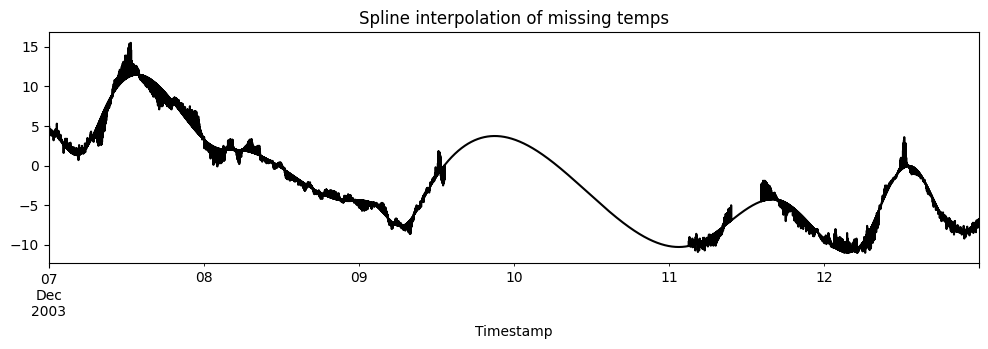

In [43]:
(one_minute_temps
    .loc['2003-12-07 ' : '2003-12-12', 'degrees']
    .plot(title='Spline interpolation of missing temps',
         figsize=(12,3)));


Choosing an interpolation technique is an art

### String Fields 

• Numeric abstraction of text

• Identification of embedded numbers

• String distance measures

• Phonetic canonicalization

• Categorical versus small distinct value count

• Uncommon values and factor levels

• Parsing non-atomic fields into varying data types

Data Scientists : "We don't want books, articles or magazines. But rather categorical, numeric, ordinal or date information"

In [45]:
df = pd.read_fwf('data/parts2.fwf')
df

,Part_No,Description,Maker,Price
0,12345,Wankle rotary engine,Acme Corporation,$ 555.55
1,No.678,Sousaphone,Marching Inc.,$ 333.33
2,2468,Feather Duster,Sweeps Bros,$ 22.22
3,#9922,Area 51 metal fragment,No Such Agency,$9999.99


In [64]:
# Problem : A dataset has a number of similar family names, that comes from various language but can represent the same person or family 

In [65]:
names = pd.read_csv('data/names.csv')
names

,Group,Last_Name,Other_Data
0,1,Levenshtein,103
1,1,Levenschtein,158
2,1,Levenstein,110
3,2,Hagelin,136
...,...,...,...
54,6,Joung,168
55,6,Chong,101
56,6,Cheong,133
57,6,Choung,104


In [66]:
# The metaphone package and the function doublemethapone() produces a pair of primary/secondary encodings for every input string 

In [81]:
from metaphone import doublemetaphone
metas = zip(*names.Last_Name.map(doublemetaphone))
names['meta1'], names['meta2'] = metas

In [82]:
with show_more_rows():
    print(names.iloc[6])

Group               2
Last_Name     Heislen
Other_Data        181
meta1             HLN
meta2                
Name: 6, dtype: object


In [83]:
with show_more_rows():
    print(names.loc[5])

Group                2
Last_Name     Haugland
Other_Data         190
meta1            HKLNT
meta2                 
Name: 5, dtype: object


### Explicit categories

In [85]:
# Problem : Most names are probably mispelling  

humans = pd.read_csv('data/humans-names.csv')
humans

,Name,Height,Weight
0,James,167.089607,64.806216
1,David,181.648633,78.281527
2,Barbara,176.272800,87.767722
3,John,173.270164,81.635672
...,...,...,...
24996,Michael,163.952580,68.936137
24997,Marie,164.334317,67.830516
24998,Robert,171.524117,75.861686
24999,James,174.949129,71.620899


In [86]:
name_counts = humans.Name.value_counts()
uncommon = name_counts[name_counts < 10]
humans = (humans
          .set_index('Name')
          .drop(uncommon.index)
          .reset_index())

humans

,Name,Height,Weight
0,James,167.089607,64.806216
1,David,181.648633,78.281527
2,Barbara,176.272800,87.767722
3,John,173.270164,81.635672
...,...,...,...
24579,Michael,163.952580,68.936137
24580,Marie,164.334317,67.830516
24581,Robert,171.524117,75.861686
24582,James,174.949129,71.620899


In [89]:
# Only 18 unique names remaining 

humans['Name'] = humans.Name.astype('category')
humans.Name.dtype

CategoricalDtype(categories=['Barbara', 'David', 'Elizabeth', 'James', 'Jennifer',
                  'Jessica', 'John', 'Jon', 'Joseph', 'Linda', 'Marie', 'Mary',
                  'Michael', 'Patricia', 'Richard', 'Robert', 'Susan',
                  'William'],
, ordered=False, categories_dtype=object)

In [90]:
humans[humans.Name == 'Mary']

,Name,Height,Weight
19,Mary,170.513197,71.145258
35,Mary,175.783570,73.843096
54,Mary,166.074242,70.826540
61,Mary,175.258933,78.888337
...,...,...,...
24532,Mary,172.602398,72.602118
24536,Mary,172.159574,70.383305
24547,Mary,173.902497,71.545191
24549,Mary,169.510964,71.460077


In [93]:
%%R
# Analyzing the same dataset in R
# Advantage : Easy conversion between factor variables and the underlying datatype

humans <- read_csv('data/humans-names.csv')
humans

Rows: 25000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Name
dbl (2): Height, Weight

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 25,000 × 3
   Name      Height Weight
   <chr>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# … with 24,990 more rows


In [95]:
%%R 

# Make the column name into a factor variable
humans <- mutate_at(humans, vars(Name), factor)

# Any values occurring fewer than 100 times will be added to the factor variable 'UNCOMMON'

humans['Name'] <- fct_lump_min(humans$Name, min = 100, other_level = 'UNCOMMON')
humans

# A tibble: 25,000 × 3
   Name      Height Weight
   <fct>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# … with 24,990 more rows


In [97]:
%%R 
levels(humans$Name)

 [1] "Barbara"   "David"     "Elizabeth" "James"     "Jennifer"  "Jessica"  
 [7] "John"      "Jon"       "Joseph"    "Linda"     "Marie"     "Mary"     
[13] "Michael"   "Patricia"  "Richard"   "Robert"    "Susan"     "William"  
[19] "UNCOMMON" 


In [98]:
%%R


humans %>% filter(Name == 'UNCOMMON')

# A tibble: 417 × 3
   Name     Height Weight
   <fct>     <dbl>  <dbl>
 1 UNCOMMON   172.   76.5
 2 UNCOMMON   167.   60.3
 3 UNCOMMON   182.   85.2
 4 UNCOMMON   176.   72.3
 5 UNCOMMON   174.   82.1
 6 UNCOMMON   170.   66.8
 7 UNCOMMON   171.   60.0
 8 UNCOMMON   171.   73.9
 9 UNCOMMON   171.   80.4
10 UNCOMMON   177.   73.3
# … with 407 more rows


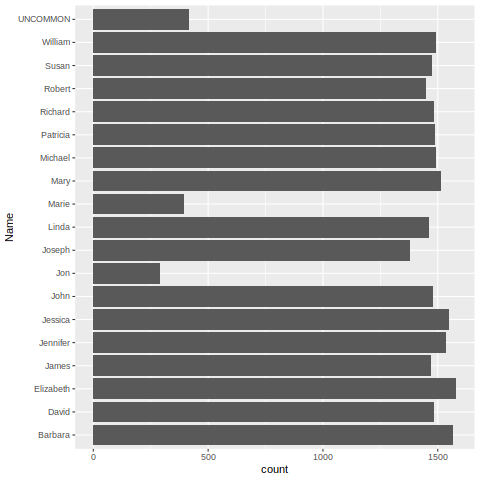

In [100]:
%%R 
# Checking the distribution plot 
ggplot(humans, aes(y = Name)) + geom_bar(stat = 'count')

### String Vectors

Strings in the natural language processing sense : texts of human languages which we might transform
into numeric representations.

Concepts:

• Bag-of-words

• Word2Vec

• Cosine similarity

• Stop words, tokenization, lemmatization

How can you encode strings of natural language into numeric features ? 

In [102]:
# William Butler Yeats

second_coming = """
Turning and turning in the widening gyre
The falcon cannot hear the falconer;
Things fall apart; the centre cannot hold;
Mere anarchy is loosed upon the world,
The blood-dimmed tide is loosed, and everywhere
The ceremony of innocence is drowned;
The best lack all conviction, while the worst
Are full of passionate intensity.
Surely some revelation is at hand;
Surely the Second Coming is at hand.
The Second Coming! Hardly are those words out
When a vast image out of Spiritus Mundi
Troubles my sight: somewhere in sands of the desert
A shape with lion body and the head of a man,
A gaze blank and pitiless as the sun,
Is moving its slow thighs, while all about it
Reel shadows of the indignant desert birds.
The darkness drops again; but now I know
That twenty centuries of stony sleep
Were vexed to nightmare by a rocking cradle,
And what rough beast, its hour come round at last,
Slouches towards Bethlehem to be born?
"""

In [110]:
# Problem 1 : Reduce the mote to a sequence of more canonical words  (Tokenization)

def simplify_text(text):
    stops = nltk.corpus.stopwords.words('english')
    words = re.findall(r'[a-z]+', text.lower())
    return [w for w in words if w not in stops]

poem = simplify_text(second_coming)
poem[:6]


['turning', 'turning', 'widening', 'gyre', 'falcon', 'cannot']

In [107]:
# Goal encode each fragment (any kind of division in the data) using a vector

In [106]:
word2ndx = {w:n for (n, w) in enumerate(set(poem))}
print(f"Vector dimensions={len(word2ndx)}")

def make_vector(words, word2ndx=word2ndx):
    # Generate the vector of zero count per dimension
    vec = np.zeros(len(word2ndx), dtype=np.uint16)
    for word in words:

            # we might ignore unknown word or attempt
            # to canonicalize it, here we raise exception
            assert word in word2ndx
            n = word2ndx[word]
            vec[n] += 1
    return vec
list(word2ndx.items())[:5]

Vector dimensions=84


[('darkness', 0), ('sun', 1), ('image', 2), ('turning', 3), ('vast', 4)]

In [116]:
# Encode each stanza or fragment as a vector 

for i, stanza in enumerate(second_coming.split('\n\n')):
    print(f'Stanza {i+1}:')
    print(make_vector(simplify_text(stanza)))

Stanza 1:
[1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 2]


In [117]:
# These vectors above represent a distinction between the meaning of the two stanzas 

In [119]:
# Ilustrating Word2Vec

db = sqlite3.connect('data/Airline-Tweets.sqlite')
cur = db.cursor()

sql = """
    SELECT name, airline, text
    FROM Tweets
"""

cur.execute(sql)
tweets = cur.fetchall()
pprint(tweets[5000:5003], width=60)

[('Paul_Faust',
  'United',
  '@united Love to report how horrible this flight is to '
  "your team. Let's make it worse...as they get to my "
  'seat...out of all snacks'),
 ('Jennsaint8',
  'Southwest',
  '@SouthwestAir any chance they will change this to '
  'include Northeast airports?  JetBlue has.'),
 ('_stephanieejayy',
  'Delta',
  '@JetBlue do you have any afternoon flights going from '
  'BQN to JFK? I only seem to find early morning flights.')]


In [121]:
!pip3 install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 2.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 248.5 kB/s eta 0:00:001m24.1 MB/s eta 0:00:01


In [122]:
# Ilustrating the gensim API

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = []

for (author, airline, msg) in tweets:
    td = TaggedDocument(simplify_text(msg), [author, airline])
    docs.append(td)

model = Doc2Vec(docs, vector_size=10, window=2, min_count=4)

In [125]:
msg = tweets[11_001][2]
print(msg)
model.infer_vector(simplify_text(msg))

@AmericanAir thank you for responding rather quickly btw


array([-0.14964332, -0.03346601, -0.10249715, -0.1389846 , -0.05954354,
       -0.05517555,  0.2092617 , -0.07574931, -0.31764498, -0.38325563],
      dtype=float32)

In [126]:
badservice = model.infer_vector(['bad' , 'service'])
badservice

array([-0.02554564, -0.02768496, -0.04438451, -0.14018553, -0.10809704,
       -0.07857754,  0.04561354, -0.03316664, -0.04109631, -0.10278367],
      dtype=float32)

In [127]:
model.wv.most_similar(['bad', 'service'])

[('provided', 0.9343312978744507),
 ('worse', 0.9230579733848572),
 ('july', 0.9085635542869568),
 ('part', 0.9077404141426086),
 ('disappointed', 0.9020770788192749),
 ('experienced', 0.900313138961792),
 ('fail', 0.8963047862052917),
 ('attitude', 0.8924351334571838),
 ('upset', 0.8894950151443481),
 ('nightmare', 0.8790352940559387)]

In [131]:
airlines = ('Delta', 'United', 'JetBlue')
delta, united, jetblue = (model.docvecs[x] for x in airlines)
print(f"Delta:\n{delta}\n")
print(f"United:\n{united}\n")
print(f"JetBlue:\n{jetblue}\n")



Delta:
[ -0.3979866   -1.9696087   -3.0869608   -6.275085    -1.3127531
  -1.2575351    0.90009034   5.050528   -10.164126    -8.840483  ]

United:
[ -1.7012129   -4.726956    -0.8999869   -5.741073     0.99306643
  -4.1931753    1.6685336   -1.3974644   -1.5957341  -10.233624  ]

JetBlue:
[-0.04790262 -0.05752031  0.11416654 -0.09059612  0.06250089 -0.02703419
 -0.01217271 -0.00646286  0.01464811  0.04913175]



In [132]:
from scipy.spatial.distance import cosine
# How similar is what people tweet about these airlines ? 

print(f"Delta | United | {cosine(delta, united):.3f}")
print(f"Delta | JetBlue | {cosine(delta, jetblue):.3f}")
print(f"United | JetBlue | {cosine(united, jetblue):.3f}")


Delta | United | 0.312
Delta | JetBlue | 1.108
United | JetBlue | 0.840


### Decompositions 

Concepts:

• Principal Component Analysis and other decompositions

• Whitening

• Dimensionality reduction

• Visualization with t-SNE and UMAP

### Rotation and Whitening 

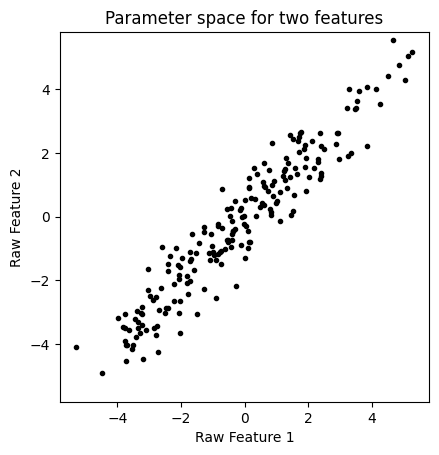

In [138]:
from src.whiten import data, show 

show(data, "Parameter space for two features", "Raw Feature 1", "Raw Feature 2")

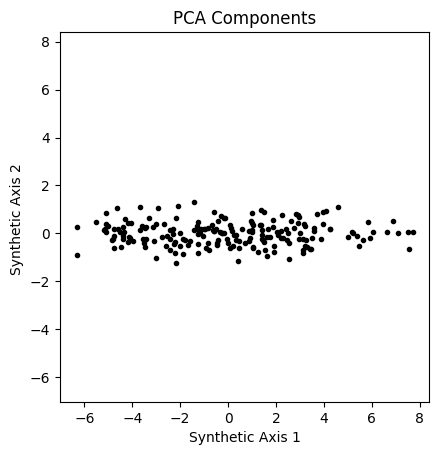

In [139]:
from sklearn.decomposition import PCA
show(PCA().fit_transform(data),
    "PCA Components", "Synthetic Axis 1", "Synthetic Axis 2 ")

Application of decomposition : Reduce the number of features while maintaining the most information possible

### Dimensionality reduction
using the Wisconsin Breast Cancer dataset

In [143]:
cancer = load_breast_cancer()
x_raw = StandardScaler().fit_transform(cancer.data)
y = cancer.target